# Histogram Sampling of Airborne Lidar Overlap Regions

Idea: 
1. Open some number of potentially overlapping scans at the same time and coarsely sample them. 
2. Find points that overlap with another flight. 
3. Add these points to a 3D histogram to denote overlap regions. 
4. Collect all points in bins with points that have many neighbors

In [1]:
import time
import numpy as np
from pathos.multiprocessing import ProcessingPool as Pool
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import pandas as pd
from pathlib import Path
from pptk import kdtree
from tqdm import tqdm, trange

In [2]:
# Some options to play with
sample_overlap_size = int(10e3)
pc1_path = '39' # '1'
pc2_path = '3'  # '15' 

# Some examples of various types of overlap
# 1 and 10 - 1 is bisected by 10
# 1 and 37 - 1 and 37 are parallel with small overlap
# 1 and 3  - 1 and 3 are parallel with no overlap


In [3]:
# Get our point clouds ready to load in 
pc_dir = Path("../dublin/npy/")
pc_paths = {f.stem:f.absolute() for f in pc_dir.glob("*.npy")}
print(pc_paths.keys())
# pc = np.load(pc_paths['num'])

dict_keys(['26', '29', '37', '3', '21', '30', '22', '17', '9', '33', '14', '10', '11', '4', '25', '2', '40', '8', '16', '12', '35', '23', '5', '34', '36', '24', '31', '28', '20', '27', '7', '13', '15', '0', '38', '19', '6', '39', '1', '18', '32'])


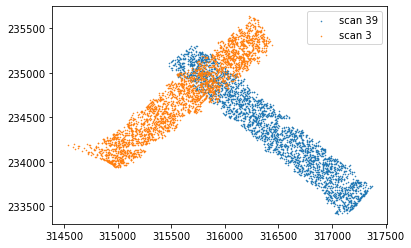

In [4]:
# Initial visualization of our point clouds to visually check for overlap
pc1 = np.load(pc_paths[pc1_path])
pc2 = np.load(pc_paths[pc2_path])

pc1_vis_s = pc1[np.random.choice(len(pc1), size=3000, replace=False)]
pc2_vis_s = pc2[np.random.choice(len(pc2), size=3000, replace=False)]

plt.scatter(pc1_vis_s[:, 0], pc1_vis_s[:, 1], s=0.3, label=f"scan {pc1_path}")
plt.scatter(pc2_vis_s[:, 0], pc2_vis_s[:, 1], s=0.3, label=f"scan {pc2_path}")

plt.legend()
plt.show()

In [5]:
def get_hist_overlap(pc1, pc2, sample_overlap_size=10000, hist_bin_length=10):
    # Params:
    #     pc1: point cloud 1 (np array with shape ([m, k1]))
    #     pc2: point cloud 2 (np array with shape ([n, k2]))
    #
    # k1 and k2 must contain at least x and y coordinates. 
    
    #
    # Returns:
    #     
    
    # define a data range
    pc_combined = np.concatenate((pc1, pc2))
    data_range = np.array(
        [[pc_combined[:, 0].min(), pc_combined[:, 0].max()],
        [pc_combined[:, 1].min(), pc_combined[:, 1].max()],
        [pc_combined[:, 2].min(), pc_combined[:, 2].max()]])
    
    bin_counts = [int((f[1]-f[0])/hist_bin_length) for f in data_range]

    del pc_combined  # save some mem
    
    # define bins based on data_range:
    x_bins = np.linspace(data_range[0][0], data_range[0][1], num=bin_counts[0])
    y_bins = np.linspace(data_range[1][0], data_range[1][1], num=bin_counts[1])
    z_bins = np.linspace(data_range[2][0], data_range[2][1], num=bin_counts[2])
    
    # Collect some number of points as overlap between these point clouds
    # build kd tree so we can search for points in pc2
    kd = kdtree._build(pc2[:, :3])

    # collect a sample of points in pc1 to query in pc2
    sample_overlap = np.random.choice(len(pc1), size=sample_overlap_size)
    pc1_sample = pc1[sample_overlap]

    # query pc1 sample in pc2. note that we want lots of nearby neighbors
    query = kdtree._query(kd, pc1_sample[:, :3], k=150, dmax=1)
    
    # Count the number of neighbors found at each query point
    counts = np.zeros((len(query), 1))
    for i in range(len(query)):
        counts[i][0] = len(query[i])

    # Append this to our sample
    pc1_sample_with_counts = np.concatenate((pc1_sample[:, :3], counts), axis=1)

    # this needs to be transformed such that the points (X, Y) occur in the
    # array `count` times. This will make histogram creation easier.
    rows = []
    for i in range(len(pc1_sample_with_counts)):
        row = pc1_sample_with_counts[i, :3]
        row = np.expand_dims(row, 0)
        if pc1_sample_with_counts[i, 2]:
            duplication = np.repeat(row, pc1_sample_with_counts[i, 3], axis=0)
            rows.append(duplication)
    
    pc1_sample_f = np.concatenate(rows, axis=0)
    
    # build histogram over data
    hist, edges = np.histogramdd(
        pc1_sample_f[:, :3], 
        bins=[x_bins, y_bins, z_bins])

    return (hist, edges), pc1_sample_f

In [6]:
def visualize_hist(pc1, pc2, overlap_sample, hist_bin_length):
    
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.005
    
    pc_combined = np.concatenate((pc1, pc2))
    data_range = np.array(
        [[pc_combined[:, 0].min(), pc_combined[:, 0].max()],
        [pc_combined[:, 1].min(), pc_combined[:, 1].max()],
        [pc_combined[:, 2].min(), pc_combined[:, 2].max()]])
    
    bin_counts = [int((f[1]-f[0])/hist_bin_length) for f in data_range]

    del pc_combined  # save some mem
    
    # define bins based on data_range:
    x_bins = np.linspace(data_range[0][0], data_range[0][1], num=bin_counts[0])
    y_bins = np.linspace(data_range[1][0], data_range[1][1], num=bin_counts[1])
    z_bins = np.linspace(data_range[2][0], data_range[2][1], num=bin_counts[2])
    fig, ax = plt.subplots(figsize=(17, 12))
    
    vs1 = np.random.choice(len(pc1), size=5000, replace=False)
    vs2 = np.random.choice(len(pc2), size=5000, replace=False)
    ax.scatter(pc1[vs1, 0], pc1[vs1, 1], s=10, label=f"scan 1")
    ax.scatter(pc2[vs2, 0], pc2[vs2, 1], s=10, label=f"scan 2")
    
    ax.set_title("Histogram of Overlap Region")

    hist, xedges, yedges, qm = ax.hist2d(
        overlap_sample[:, 0], 
        overlap_sample[:, 1], 
        bins=[x_bins, y_bins],
        # range=data_range,
        # density=True,
        norm=colors.LogNorm())


    # ax.legend()
    plt.show()

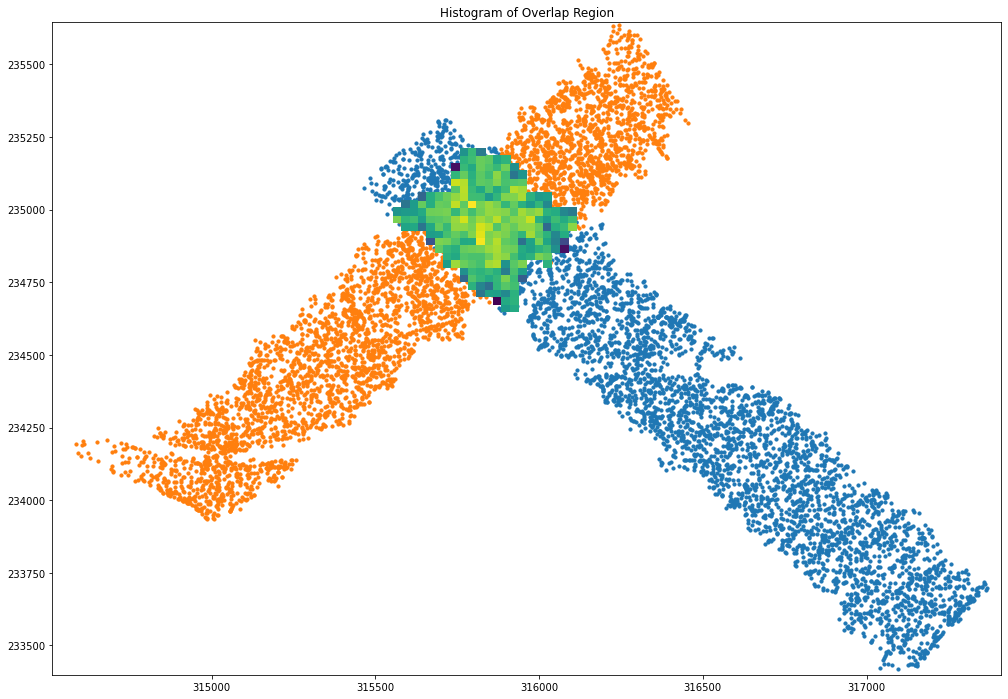

CPU times: user 15.1 s, sys: 2.56 s, total: 17.6 s
Wall time: 9.37 s


In [7]:
%%time
# Visualize this data
# bin length of 10 seems reasonable, but could maybe go slightly higher
hist_info, overlap_sample = get_hist_overlap(pc1, pc2, hist_bin_length=25)
visualize_hist(pc1, pc2, overlap_sample, 25)



In [8]:
def get_overlap_points(pc, hist_info, c):
    # Pull points out of `pc` from overlap information to be used in dataset
    # creation.
    #   `hist_info`: tuple (hist, bins) 
    #   `c` : the count of required overlap points to exist in a bin for it to
    #       to count as being "in the overlap." Higher values of c grab points 
    #       more likely to be in the overlap.

    def get_indices(e):
        x1, x2, y1, y2, z1, z2 = e

        # this is very slow :/
        new_indices = ((x1 <= pc[:, 0]) & (pc[:, 0] < x2) &
                       (y1 <= pc[:, 1]) & (pc[:, 1] < y2) &
                       (z1 <= pc[:, 2]) & (pc[:, 2] < z2))

        return new_indices

    indices = np.full(pc.shape[0], False, dtype=bool)
    process_list = []
    hist, (xedges, yedges, zedges) = hist_info
    
    h_iter = np.array(np.meshgrid(
        np.arange(hist.shape[0]), 
        np.arange(hist.shape[1]),
        np.arange(hist.shape[2])
    )).T.reshape(-1, 3)
    
    for t in tqdm(h_iter, desc="building process list"):
        i, j, k = t
        if hist[i][j][k] > c:
            x1, x2 = xedges[i], xedges[i+1]
            y1, y2 = yedges[j], yedges[j+1]
            z1, z2 = zedges[k], zedges[k+1]
            process_list.append((x1, x2, y1, y2, z1, z2))
            
    process_list = np.array(process_list)
    
    for t in tqdm(process_list, desc="compiling indices"):
        indices = indices | get_indices(t)
        
    return indices

In [9]:
%%time
overlap_idx = get_overlap_points(pc1, hist_info, 1)
pc_overlap = pc1[overlap_idx]
print(f"Filtered out {(100*(pc1.shape[0]-pc_overlap.shape[0])/(pc1.shape[0])):.2f}% of points")

compiling indices: 100%|██████████| 394/394 [04:38<00:00,  1.41it/s]

Filtered out 82.06% of points
CPU times: user 4min 31s, sys: 7.15 s, total: 4min 38s
Wall time: 4min 39s


In [10]:
print(overlap_idx.shape)

(41703116,)


(7481758, 9)


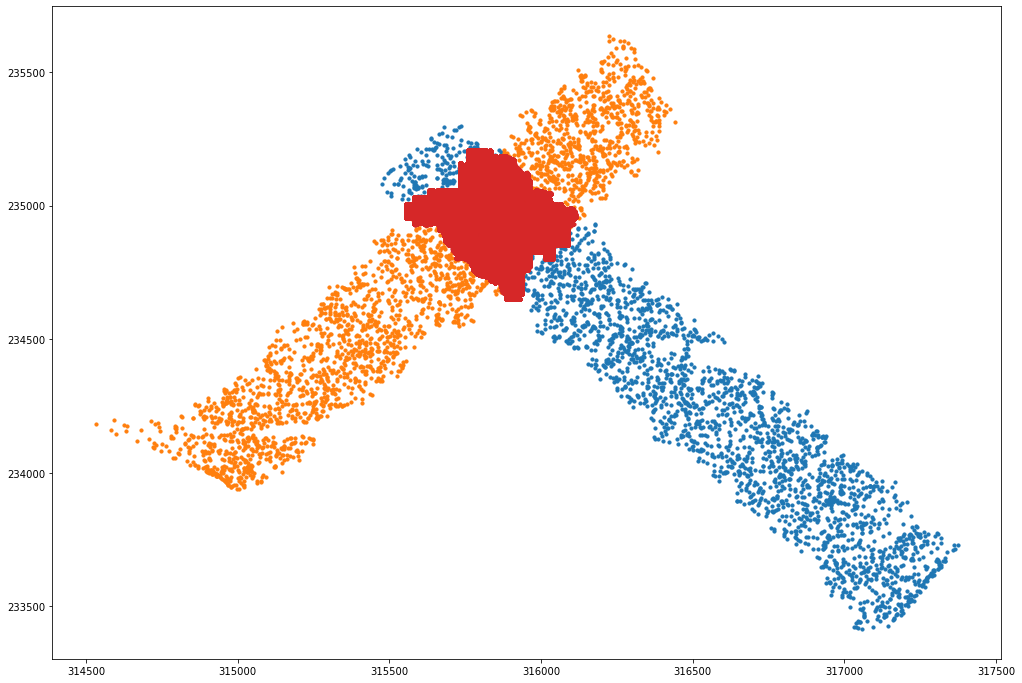

In [11]:
print(pc_overlap.shape)
fig, ax = plt.subplots(figsize=(17, 12))

ax.scatter(pc1_vis_s[:, 0], pc1_vis_s[:, 1], s=10)
ax.scatter(pc2_vis_s[:, 0], pc2_vis_s[:, 1], s=10)
ax.scatter(pc_overlap[:, 0], pc_overlap[:, 1], s=10, c='tab:red')

plt.show()

In [14]:
%%time
# Non-overlap region of source scan?
overlap_idx = get_overlap_points(pc2, hist_info, 1)

compiling indices: 100%|██████████| 355/355 [04:50<00:00,  1.22it/s]

CPU times: user 4min 26s, sys: 22.5 s, total: 4min 49s
Wall time: 4min 50s


(43368738,)
(43368738, 9)
(6710935, 9)


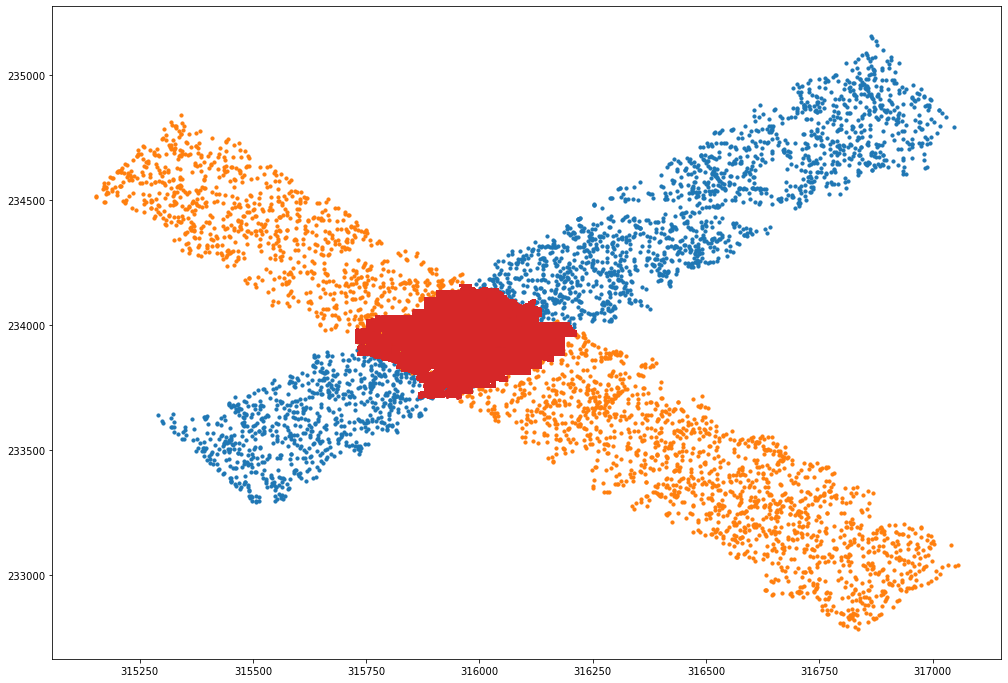

In [15]:
print(overlap_idx.shape)
print(pc2.shape)

pc_overlap = pc2[overlap_idx]
print(pc_overlap.shape)

fig, ax = plt.subplots(figsize=(17, 12))

ax.scatter(pc1_vis_s[:, 0], pc1_vis_s[:, 1], s=10)
ax.scatter(pc2_vis_s[:, 0], pc2_vis_s[:, 1], s=10)
ax.scatter(pc_overlap[:, 0], pc_overlap[:, 1], s=3, c='tab:red')

plt.show()

bool
(43368738,)
(6710935,)
(36657803, 9)
(43368738, 9)


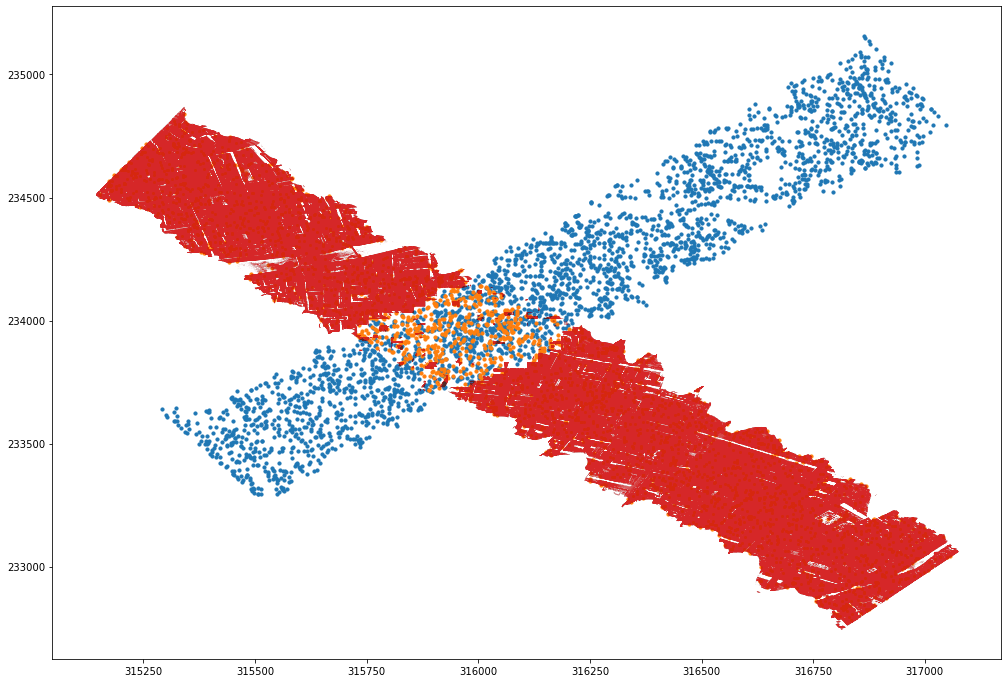

In [16]:
pc2_no_overlap = pc2[~overlap_idx]
print(overlap_idx.dtype)
print(overlap_idx.shape)
print(overlap_idx[overlap_idx>0].shape)
print(pc2_no_overlap.shape)
print(pc2.shape)
fig, ax = plt.subplots(figsize=(17, 12))

ax.scatter(pc1_vis_s[:, 0], pc1_vis_s[:, 1], s=10)
ax.scatter(pc2_vis_s[:, 0], pc2_vis_s[:, 1], s=10)
ax.scatter(pc2_no_overlap[:, 0], pc2_no_overlap[:, 1], s=0.00001, c='tab:red')

plt.show()